In [2]:
import warnings 
warnings.filterwarnings("ignore")

from monai.utils import first, set_determinism
from monai.transforms import (
    AddChanneld,
    AsChannelFirstd,
    AsDiscrete,
    AsDiscreted,
    Compose,
    EnsureChannelFirstd,
    EnsureTyped,
    EnsureType,
    Invertd,
    LabelFilterd,
    Lambdad,
    LoadImaged,
    RandFlipd,
    RandSpatialCropd,
    RandZoomd,
    Resized,
    ScaleIntensityRanged,
    SpatialCrop,
    SpatialCropd,
    ToTensord,
)
from monai.handlers.utils import from_engine
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.metrics import DiceMetric
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, DataLoader, Dataset, decollate_batch
from monai.config import print_config
from monai.apps import download_and_extract
import torch
import matplotlib.pyplot as plt
import tempfile
import shutil
import os
from glob import glob

import numpy as np

import itk

import sys

import site
site.addsitedir('../')
from ARGUSUtils_Transforms import *

In [3]:
device_num = 2

img1_dir = "../../Data/Final15/BAMC-PTX*Sliding-Annotations-Linear/"
    
all_images = sorted(glob(os.path.join(img1_dir, '*_?????.nii.gz')))
all_labels = sorted(glob(os.path.join(img1_dir, '*.interpolated-overlay.nii.gz')))

num_folds = 15

num_classes = 3

max_epochs = 1000

net_dims = 3
net_in_channels = 1
net_channels=(16, 32, 64, 128, 32)
net_strides=(2, 2, 2, 2)

num_workers_tr = 4
batch_size_tr = 8
num_workers_vl = 2
batch_size_vl = 2

num_slices = 48
size_x = 320
size_y = 320


model_filename_base = "./results/BAMC_PTX_ARUNet-3D-PR-Final15-Full"

In [4]:
if not os.path.exists(model_filename_base):
    os.mkdir(model_filename_base)

model_filename_base = model_filename_base+"/"

In [5]:
num_images = len(all_images)
print("Num images / labels =", num_images, len(all_labels))

ns_prefix = ['025ns','026ns','027ns','035ns','048ns','055ns','117ns',
             '135ns','193ns','210ns','215ns','218ns_image_60','218ns_image_63','219ns','247ns']
s_prefix = ['004s','019s','030s','034s','037s','043s','065s','081s',
            '206s','208s','211s','212s','224s','228s','236s','237s']

train_files =  []
train_files.append([
    {"image": img, "label": seg}
    for img, seg in zip(
        [im for im in all_images if any(pref in im for pref in ns_prefix)],
        [se for se in all_labels if any(pref in se for pref in ns_prefix)])
    ])
train_files.append([
    {"image": img, "label": seg}
    for img, seg in zip(
        [im for im in all_images if any(pref in im for pref in s_prefix)],
        [se for se in all_labels if any(pref in se for pref in s_prefix)])
    ])
train_files.append([
    {"image": img, "label": seg}
    for img, seg in zip(
        [im for im in all_images if any(pref in im for pref in ns_prefix)],
        [se for se in all_labels if any(pref in se for pref in ns_prefix)])
    ])
train_files = list(np.concatenate(train_files).flat)
print(len(train_files))

Num images / labels = 47 47
62


../../Data/Final15/BAMC-PTXNoSliding-Annotations-Linear/025ns_image_267456908021_clean.nii.gz
../../Data/Final15/BAMC-PTXNoSliding-Annotations-Linear/025ns_image_267456908021_clean.interpolated-overlay.nii.gz
Labels =  0 - 2


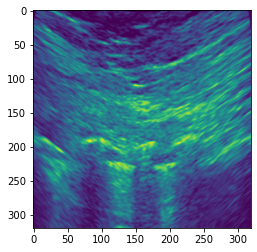

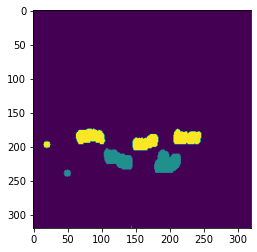

In [6]:
imgnum = 0 #30 for s, 0 for ns

print(train_files[imgnum]["image"])
print(train_files[imgnum]["label"])

img = itk.imread(train_files[imgnum]["image"])
arrimg = itk.GetArrayFromImage(img)
img = itk.imread(train_files[imgnum]["label"])
arrlbl = itk.GetArrayFromImage(img)

plt.subplots()
plt.imshow(arrimg[0,:,:])
plt.subplots()
plt.imshow(arrlbl[0,:,:])
print("Labels = ", arrlbl[:,:,:].min(), "-", arrlbl[:,:,:].max())

In [7]:
train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        AddChanneld(keys=['image','label']),
        ScaleIntensityRanged(
            a_min=0, a_max=255,
            b_min=0.0, b_max=1.0,
            keys=["image"]),
        Lambdad(
            func=lambda x: np.where(x==3,1,x),
            keys=['label']),
        ARGUS_RandSpatialCropSlicesd(
            num_slices=num_slices,
            axis=3,
            keys=['image', 'label']),
        RandFlipd(prob=0.5, 
            spatial_axis=0,
            keys=['image', 'label']),
        RandFlipd(prob=0.5, 
            spatial_axis=2,
            keys=['image', 'label']),
        RandZoomd(prob=0.5, 
            min_zoom=1.0,
            max_zoom=1.2,
            keep_size=True,
            mode=['trilinear', 'nearest'],
            keys=['image', 'label']),
        ToTensord(keys=["image", "label"]),
    ]
)
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        AddChanneld(keys=['image', 'label']),
        ScaleIntensityRanged(
            a_min=0, a_max=255,
            b_min=0.0, b_max=1.0,
            keys=["image"]),
        Lambdad(
            func=lambda x: np.where(x==3,1,x),
            keys=['label']),
        ARGUS_RandSpatialCropSlicesd(
            num_slices=num_slices,
            center_slice=30,
            axis=3,
            keys=['image', 'label']),
        ToTensord(keys=["image", "label"]),
    ]
)

In [8]:
train_ds = CacheDataset(data=train_files, transform=train_transforms,cache_rate=1.0, num_workers=num_workers_tr)
train_loader = DataLoader(train_ds, batch_size=batch_size_tr, shuffle=True, num_workers=num_workers_tr) 

Loading dataset: 100%|██████████████████████████| 62/62 [00:03<00:00, 17.48it/s]


torch.Size([8, 1, 320, 320, 48])
torch.Size([1, 320, 320, 48])
image shape: torch.Size([1, 320, 320, 48]), label shape: torch.Size([1, 320, 320, 48])


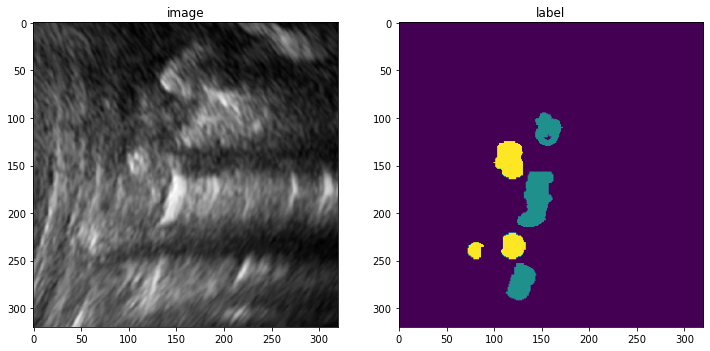

tensor(0.) tensor(2.)


In [9]:
imgnum = 0
check_data = first(train_loader)
image, label = (check_data["image"][imgnum], check_data["label"][imgnum])
print(check_data["image"].shape)
print(image.shape)
print(f"image shape: {image.shape}, label shape: {label.shape}")
plt.figure("check", (12, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(image[0, :, :, 24], cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[0, :, :, 24])
plt.show()
print(label.min(), label.max())

In [10]:
device = torch.device("cuda:"+str(device_num))

In [11]:
def net_train(train_loader):
    model = UNet(
        dimensions=net_dims,
        in_channels=net_in_channels,
        out_channels=num_classes,
        channels=net_channels,
        strides=net_strides,
        num_res_units=2,
        norm=Norm.BATCH,
    ).to(device)
    loss_function = DiceLoss(to_onehot_y=True, softmax=True)
    optimizer = torch.optim.Adam(model.parameters(), 1e-4)
    dice_metric = DiceMetric(include_background=False, reduction="mean")

    val_interval = 2
    best_metric = -1
    best_metric_epoch = -1
    epoch_loss_values = []
    metric_values = []

    post_pred = Compose([EnsureType(), AsDiscrete(argmax=True, to_onehot=True, num_classes=num_classes)])
    post_label = Compose([EnsureType(), AsDiscrete(to_onehot=True, num_classes=num_classes)])

    for epoch in range(max_epochs):
        print("-" * 10)
        print(f"Epoch {epoch + 1}/{max_epochs}")
        model.train()
        epoch_loss = 0
        step = 0
        for batch_data in train_loader:
            step += 1
            inputs, labels = (
                batch_data["image"].to(device),
                batch_data["label"].to(device),
            )
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            print(f"{step}/{len(train_ds) // train_loader.batch_size}, "
                  f"train_loss: {loss.item():.4f}")
        epoch_loss /= step
        epoch_loss_values.append(epoch_loss)
        print(f"Epoch {epoch + 1} average loss: {epoch_loss:.4f}")

        if (epoch + 1) % val_interval == 0:
            model.eval()
            with torch.no_grad():
                for val_data in train_loader:
                    val_inputs, val_labels = (
                        val_data["image"].to(device),
                        val_data["label"].to(device),
                    )
                    roi_size = (size_x, size_y, num_slices)
                    sw_batch_size = batch_size_vl
                    val_outputs = sliding_window_inference(
                        val_inputs, roi_size, sw_batch_size, model)
                    val_outputs = [post_pred(i) for i in decollate_batch(val_outputs)]
                    val_labels = [post_label(i) for i in decollate_batch(val_labels)]
                    # compute metric for current iteration
                    dice_metric(y_pred=val_outputs, y=val_labels)

                # aggregate the final mean dice result
                metric = dice_metric.aggregate().item()
                # reset the status for next validation round
                dice_metric.reset()

                metric_values.append(metric)
                if epoch > 100:
                    metric = (metric_values[-1]+metric_values[-2]+metric_values[-3])/3
                    if metric > best_metric:
                        best_metric = metric
                        best_metric_epoch = epoch + 1
                        torch.save(model.state_dict(), model_filename_base+'best_model.pth')
                        print("saved new best metric model")
                if epoch == max_epochs // 3:
                    torch.save(model.state_dict(), model_filename_base+'Epoch'+str(epoch)+'_model.pth')
                if epoch == (2*max_epochs) // 3:
                    torch.save(model.state_dict(), model_filename_base+'Epoch'+str(epoch)+'_model.pth')
                print(
                    f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                    f"\nbest mean dice: {best_metric:.4f} "
                    f"at epoch: {best_metric_epoch}"
                )
                torch.save(model.state_dict(), model_filename_base+'last_model.pth')

    np.save(model_filename_base+"loss_"+str(vfold_num)+".npy", epoch_loss_values)
    np.save(model_filename_base+"val_dice_"+str(vfold_num)+".npy", metric_values)

    

In [ ]:
net_train(train_loader)

----------
Epoch 1/1000
1/7, train_loss: 0.7924
2/7, train_loss: 0.7857
3/7, train_loss: 0.7803
4/7, train_loss: 0.7848
5/7, train_loss: 0.7820
6/7, train_loss: 0.7753
7/7, train_loss: 0.7703
8/7, train_loss: 0.7708
Epoch 1 average loss: 0.7802
----------
Epoch 2/1000
1/7, train_loss: 0.7640
2/7, train_loss: 0.7572
3/7, train_loss: 0.7574
4/7, train_loss: 0.7535
5/7, train_loss: 0.7499
6/7, train_loss: 0.7511
7/7, train_loss: 0.7542
8/7, train_loss: 0.7346
Epoch 2 average loss: 0.7527
current epoch: 2 current mean dice: 0.1115
best mean dice: -1.0000 at epoch: -1
----------
Epoch 3/1000
1/7, train_loss: 0.7478
2/7, train_loss: 0.7342
3/7, train_loss: 0.7432
4/7, train_loss: 0.7333
5/7, train_loss: 0.7321
6/7, train_loss: 0.7375
7/7, train_loss: 0.7294
8/7, train_loss: 0.7282
Epoch 3 average loss: 0.7357
----------
Epoch 4/1000
1/7, train_loss: 0.7321
2/7, train_loss: 0.7317
3/7, train_loss: 0.7330
4/7, train_loss: 0.7259
5/7, train_loss: 0.7185
6/7, train_loss: 0.7204
7/7, train_loss: 

7/7, train_loss: 0.5643
8/7, train_loss: 0.5541
Epoch 29 average loss: 0.5616
----------
Epoch 30/1000
1/7, train_loss: 0.5534
2/7, train_loss: 0.5428
3/7, train_loss: 0.5592
4/7, train_loss: 0.5671
5/7, train_loss: 0.5738
6/7, train_loss: 0.5802
7/7, train_loss: 0.5747
8/7, train_loss: 0.5103
Epoch 30 average loss: 0.5577
current epoch: 30 current mean dice: 0.4747
best mean dice: -1.0000 at epoch: -1
----------
Epoch 31/1000
1/7, train_loss: 0.5584
2/7, train_loss: 0.5478
3/7, train_loss: 0.5476
4/7, train_loss: 0.5638
5/7, train_loss: 0.5384
6/7, train_loss: 0.5464
7/7, train_loss: 0.5652
8/7, train_loss: 0.5494
Epoch 31 average loss: 0.5521
----------
Epoch 32/1000
1/7, train_loss: 0.5086
2/7, train_loss: 0.5680
3/7, train_loss: 0.5703
4/7, train_loss: 0.5438
5/7, train_loss: 0.5626
6/7, train_loss: 0.5451
7/7, train_loss: 0.5635
8/7, train_loss: 0.5434
Epoch 32 average loss: 0.5507
current epoch: 32 current mean dice: 0.4519
best mean dice: -1.0000 at epoch: -1
----------
Epoch 33

3/7, train_loss: 0.4450
4/7, train_loss: 0.4506
5/7, train_loss: 0.4532
6/7, train_loss: 0.4643
7/7, train_loss: 0.4291
8/7, train_loss: 0.4354
Epoch 58 average loss: 0.4395
current epoch: 58 current mean dice: 0.6358
best mean dice: -1.0000 at epoch: -1
----------
Epoch 59/1000
1/7, train_loss: 0.4286
2/7, train_loss: 0.4253
3/7, train_loss: 0.4355
4/7, train_loss: 0.4226
5/7, train_loss: 0.4332
6/7, train_loss: 0.4299
7/7, train_loss: 0.4234
8/7, train_loss: 0.4657
Epoch 59 average loss: 0.4330
----------
Epoch 60/1000
1/7, train_loss: 0.4527
2/7, train_loss: 0.4329
3/7, train_loss: 0.4015
4/7, train_loss: 0.4473
5/7, train_loss: 0.4224
6/7, train_loss: 0.4601
7/7, train_loss: 0.4181
8/7, train_loss: 0.4258
Epoch 60 average loss: 0.4326
current epoch: 60 current mean dice: 0.6482
best mean dice: -1.0000 at epoch: -1
----------
Epoch 61/1000
1/7, train_loss: 0.3916
2/7, train_loss: 0.4568
3/7, train_loss: 0.4572
4/7, train_loss: 0.4274
5/7, train_loss: 0.4257
6/7, train_loss: 0.4200
7

current epoch: 86 current mean dice: 0.6815
best mean dice: -1.0000 at epoch: -1
----------
Epoch 87/1000
1/7, train_loss: 0.3202
2/7, train_loss: 0.3546
3/7, train_loss: 0.3123
4/7, train_loss: 0.3057
5/7, train_loss: 0.3093
6/7, train_loss: 0.3325
7/7, train_loss: 0.3462
8/7, train_loss: 0.2816
Epoch 87 average loss: 0.3203
----------
Epoch 88/1000
1/7, train_loss: 0.3324
2/7, train_loss: 0.3191
3/7, train_loss: 0.3220
4/7, train_loss: 0.3168
5/7, train_loss: 0.3177
6/7, train_loss: 0.2996
7/7, train_loss: 0.3433
8/7, train_loss: 0.3342
Epoch 88 average loss: 0.3231
current epoch: 88 current mean dice: 0.6693
best mean dice: -1.0000 at epoch: -1
----------
Epoch 89/1000
1/7, train_loss: 0.3300
2/7, train_loss: 0.3229
3/7, train_loss: 0.3195
4/7, train_loss: 0.3049
5/7, train_loss: 0.3136
6/7, train_loss: 0.3222
7/7, train_loss: 0.2949
8/7, train_loss: 0.3391
Epoch 89 average loss: 0.3184
----------
Epoch 90/1000
1/7, train_loss: 0.2856
2/7, train_loss: 0.2959
3/7, train_loss: 0.3253


saved new best metric model
current epoch: 114 current mean dice: 0.7548
best mean dice: 0.7548 at epoch: 114
----------
Epoch 115/1000
1/7, train_loss: 0.2364
2/7, train_loss: 0.2452
3/7, train_loss: 0.2401
4/7, train_loss: 0.2350
5/7, train_loss: 0.2085
6/7, train_loss: 0.2415
7/7, train_loss: 0.2513
8/7, train_loss: 0.2699
Epoch 115 average loss: 0.2410
----------
Epoch 116/1000
1/7, train_loss: 0.2345
2/7, train_loss: 0.2424
3/7, train_loss: 0.2211
4/7, train_loss: 0.2572
5/7, train_loss: 0.2364
6/7, train_loss: 0.2454
7/7, train_loss: 0.2442
8/7, train_loss: 0.2174
Epoch 116 average loss: 0.2373
current epoch: 116 current mean dice: 0.7500
best mean dice: 0.7548 at epoch: 114
----------
Epoch 117/1000
1/7, train_loss: 0.2520
2/7, train_loss: 0.2263
3/7, train_loss: 0.2310
4/7, train_loss: 0.2281
5/7, train_loss: 0.2295
6/7, train_loss: 0.2484
7/7, train_loss: 0.2341
8/7, train_loss: 0.2557
Epoch 117 average loss: 0.2381
----------
Epoch 118/1000
1/7, train_loss: 0.2476
2/7, train_

6/7, train_loss: 0.1730
7/7, train_loss: 0.1956
8/7, train_loss: 0.2068
Epoch 142 average loss: 0.1899
saved new best metric model
current epoch: 142 current mean dice: 0.7855
best mean dice: 0.7855 at epoch: 142
----------
Epoch 143/1000
1/7, train_loss: 0.1851
2/7, train_loss: 0.1863
3/7, train_loss: 0.1881
4/7, train_loss: 0.2038
5/7, train_loss: 0.1625
6/7, train_loss: 0.2015
7/7, train_loss: 0.2038
8/7, train_loss: 0.1658
Epoch 143 average loss: 0.1871
----------
Epoch 144/1000
1/7, train_loss: 0.1865
2/7, train_loss: 0.1908
3/7, train_loss: 0.1833
4/7, train_loss: 0.1898
5/7, train_loss: 0.1760
6/7, train_loss: 0.1948
7/7, train_loss: 0.1970
8/7, train_loss: 0.1898
Epoch 144 average loss: 0.1885
saved new best metric model
current epoch: 144 current mean dice: 0.7871
best mean dice: 0.7871 at epoch: 144
----------
Epoch 145/1000
1/7, train_loss: 0.1637
2/7, train_loss: 0.1932
3/7, train_loss: 0.1552
4/7, train_loss: 0.1879
5/7, train_loss: 0.1900
6/7, train_loss: 0.1873
7/7, trai

1/7, train_loss: 0.1548
2/7, train_loss: 0.1614
3/7, train_loss: 0.1506
4/7, train_loss: 0.1452
5/7, train_loss: 0.1690
6/7, train_loss: 0.1649
7/7, train_loss: 0.1696
8/7, train_loss: 0.1553
Epoch 170 average loss: 0.1589
saved new best metric model
current epoch: 170 current mean dice: 0.8014
best mean dice: 0.8014 at epoch: 170
----------
Epoch 171/1000
1/7, train_loss: 0.1494
2/7, train_loss: 0.1669
3/7, train_loss: 0.1658
4/7, train_loss: 0.1479
5/7, train_loss: 0.1432
6/7, train_loss: 0.1546
7/7, train_loss: 0.1610
8/7, train_loss: 0.1706
Epoch 171 average loss: 0.1574
----------
Epoch 172/1000
1/7, train_loss: 0.1666
2/7, train_loss: 0.1639
3/7, train_loss: 0.1664
4/7, train_loss: 0.1559
5/7, train_loss: 0.1380
6/7, train_loss: 0.1633
7/7, train_loss: 0.1474
8/7, train_loss: 0.1593
Epoch 172 average loss: 0.1576
saved new best metric model
current epoch: 172 current mean dice: 0.8028
best mean dice: 0.8028 at epoch: 172
----------
Epoch 173/1000
1/7, train_loss: 0.1518
2/7, trai

4/7, train_loss: 0.1351
5/7, train_loss: 0.1354
6/7, train_loss: 0.1527
7/7, train_loss: 0.1540
8/7, train_loss: 0.1286
Epoch 197 average loss: 0.1426
----------
Epoch 198/1000
1/7, train_loss: 0.1495
2/7, train_loss: 0.1478
3/7, train_loss: 0.1374
4/7, train_loss: 0.1276
5/7, train_loss: 0.1467
6/7, train_loss: 0.1418
7/7, train_loss: 0.1530
8/7, train_loss: 0.1436
Epoch 198 average loss: 0.1434
current epoch: 198 current mean dice: 0.8162
best mean dice: 0.8162 at epoch: 196
----------
Epoch 199/1000
1/7, train_loss: 0.1432
2/7, train_loss: 0.1307
3/7, train_loss: 0.1388
4/7, train_loss: 0.1356
5/7, train_loss: 0.1429
6/7, train_loss: 0.1479
7/7, train_loss: 0.1489
8/7, train_loss: 0.1451
Epoch 199 average loss: 0.1416
----------
Epoch 200/1000
1/7, train_loss: 0.1343
2/7, train_loss: 0.1399
3/7, train_loss: 0.1667
4/7, train_loss: 0.1398
5/7, train_loss: 0.1225
6/7, train_loss: 0.1361
7/7, train_loss: 0.1377
8/7, train_loss: 0.1404
Epoch 200 average loss: 0.1397
saved new best metri

4/7, train_loss: 0.1337
5/7, train_loss: 0.1273
6/7, train_loss: 0.1415
7/7, train_loss: 0.1282
8/7, train_loss: 0.1336
Epoch 225 average loss: 0.1345
----------
Epoch 226/1000
1/7, train_loss: 0.1352
2/7, train_loss: 0.1297
3/7, train_loss: 0.1377
4/7, train_loss: 0.1381
5/7, train_loss: 0.1180
6/7, train_loss: 0.1279
7/7, train_loss: 0.1225
8/7, train_loss: 0.1401
Epoch 226 average loss: 0.1312
saved new best metric model
current epoch: 226 current mean dice: 0.8237
best mean dice: 0.8237 at epoch: 226
----------
Epoch 227/1000
1/7, train_loss: 0.1344
2/7, train_loss: 0.1291
3/7, train_loss: 0.1388
4/7, train_loss: 0.1415
5/7, train_loss: 0.1345
6/7, train_loss: 0.1301
7/7, train_loss: 0.1250
8/7, train_loss: 0.1224
Epoch 227 average loss: 0.1320
----------
Epoch 228/1000
1/7, train_loss: 0.1182
2/7, train_loss: 0.1286
3/7, train_loss: 0.1471
4/7, train_loss: 0.1329
5/7, train_loss: 0.1142
6/7, train_loss: 0.1399
7/7, train_loss: 0.1343
8/7, train_loss: 0.1328
Epoch 228 average loss:

1/7, train_loss: 0.1327
2/7, train_loss: 0.1411
3/7, train_loss: 0.1198
4/7, train_loss: 0.1286
5/7, train_loss: 0.1250
6/7, train_loss: 0.1176
7/7, train_loss: 0.1215
8/7, train_loss: 0.1052
Epoch 253 average loss: 0.1239
----------
Epoch 254/1000
1/7, train_loss: 0.1197
2/7, train_loss: 0.1281
3/7, train_loss: 0.1178
4/7, train_loss: 0.1131
5/7, train_loss: 0.1226
6/7, train_loss: 0.1262
7/7, train_loss: 0.1294
8/7, train_loss: 0.1309
Epoch 254 average loss: 0.1235
saved new best metric model
current epoch: 254 current mean dice: 0.8324
best mean dice: 0.8324 at epoch: 254
----------
Epoch 255/1000
1/7, train_loss: 0.1222
2/7, train_loss: 0.1323
3/7, train_loss: 0.1149
4/7, train_loss: 0.1492
5/7, train_loss: 0.1174
6/7, train_loss: 0.1231
7/7, train_loss: 0.1119
8/7, train_loss: 0.1256
Epoch 255 average loss: 0.1246
----------
Epoch 256/1000
1/7, train_loss: 0.1160
2/7, train_loss: 0.1349
3/7, train_loss: 0.1240
4/7, train_loss: 0.1260
5/7, train_loss: 0.1158
6/7, train_loss: 0.1379

1/7, train_loss: 0.1131
2/7, train_loss: 0.1096
3/7, train_loss: 0.1202
4/7, train_loss: 0.1212
5/7, train_loss: 0.1123
6/7, train_loss: 0.1126
7/7, train_loss: 0.1258
8/7, train_loss: 0.1187
Epoch 281 average loss: 0.1167
----------
Epoch 282/1000
1/7, train_loss: 0.1170
2/7, train_loss: 0.1311
3/7, train_loss: 0.1102
4/7, train_loss: 0.1164
5/7, train_loss: 0.1145
6/7, train_loss: 0.1347
7/7, train_loss: 0.1228
8/7, train_loss: 0.1132
Epoch 282 average loss: 0.1200
current epoch: 282 current mean dice: 0.8352
best mean dice: 0.8359 at epoch: 280
----------
Epoch 283/1000
1/7, train_loss: 0.1223
2/7, train_loss: 0.1193
3/7, train_loss: 0.1150
4/7, train_loss: 0.1184
5/7, train_loss: 0.1285
6/7, train_loss: 0.1146
7/7, train_loss: 0.1300
8/7, train_loss: 0.1126
Epoch 283 average loss: 0.1201
----------
Epoch 284/1000
1/7, train_loss: 0.1224
2/7, train_loss: 0.1194
3/7, train_loss: 0.1060
4/7, train_loss: 0.1124
5/7, train_loss: 0.1174
6/7, train_loss: 0.1101
7/7, train_loss: 0.1306
8/7

1/7, train_loss: 0.1252
2/7, train_loss: 0.1006
3/7, train_loss: 0.1174
4/7, train_loss: 0.1184
5/7, train_loss: 0.1050
6/7, train_loss: 0.1119
7/7, train_loss: 0.1173
8/7, train_loss: 0.1192
Epoch 309 average loss: 0.1144
----------
Epoch 310/1000
1/7, train_loss: 0.1169
2/7, train_loss: 0.1188
3/7, train_loss: 0.1009
4/7, train_loss: 0.1114
5/7, train_loss: 0.1199
6/7, train_loss: 0.1074
7/7, train_loss: 0.1176
8/7, train_loss: 0.1218
Epoch 310 average loss: 0.1143
saved new best metric model
current epoch: 310 current mean dice: 0.8425
best mean dice: 0.8425 at epoch: 310
----------
Epoch 311/1000
1/7, train_loss: 0.1116
2/7, train_loss: 0.1063
3/7, train_loss: 0.1052
4/7, train_loss: 0.1075
5/7, train_loss: 0.1204
6/7, train_loss: 0.1049
7/7, train_loss: 0.1069
8/7, train_loss: 0.1385
Epoch 311 average loss: 0.1126
----------
Epoch 312/1000
1/7, train_loss: 0.1092
2/7, train_loss: 0.1108
3/7, train_loss: 0.1087
4/7, train_loss: 0.1226
5/7, train_loss: 0.1093
6/7, train_loss: 0.1242

1/7, train_loss: 0.1118
2/7, train_loss: 0.1050
3/7, train_loss: 0.1069
4/7, train_loss: 0.1133
5/7, train_loss: 0.1118
6/7, train_loss: 0.1089
7/7, train_loss: 0.1055
8/7, train_loss: 0.1019
Epoch 337 average loss: 0.1081
----------
Epoch 338/1000
1/7, train_loss: 0.1121
2/7, train_loss: 0.0977
3/7, train_loss: 0.1143
4/7, train_loss: 0.1021
5/7, train_loss: 0.1064
6/7, train_loss: 0.1114
7/7, train_loss: 0.1142
8/7, train_loss: 0.1151
Epoch 338 average loss: 0.1092
current epoch: 338 current mean dice: 0.8448
best mean dice: 0.8467 at epoch: 334
----------
Epoch 339/1000
1/7, train_loss: 0.1101
2/7, train_loss: 0.1086
3/7, train_loss: 0.1079
4/7, train_loss: 0.1078
5/7, train_loss: 0.1165
6/7, train_loss: 0.1164
7/7, train_loss: 0.0988
8/7, train_loss: 0.1072
Epoch 339 average loss: 0.1092
----------
Epoch 340/1000
1/7, train_loss: 0.1115
2/7, train_loss: 0.0938
3/7, train_loss: 0.1052
4/7, train_loss: 0.1126
5/7, train_loss: 0.1191
6/7, train_loss: 0.1094
7/7, train_loss: 0.1071
8/7

1/7, train_loss: 0.1021
2/7, train_loss: 0.1139
3/7, train_loss: 0.1078
4/7, train_loss: 0.1150
5/7, train_loss: 0.0978
6/7, train_loss: 0.1117
7/7, train_loss: 0.0928
8/7, train_loss: 0.1141
Epoch 365 average loss: 0.1069
----------
Epoch 366/1000
1/7, train_loss: 0.1059
2/7, train_loss: 0.1117
3/7, train_loss: 0.1169
4/7, train_loss: 0.1039
5/7, train_loss: 0.0969
6/7, train_loss: 0.0912
7/7, train_loss: 0.1037
8/7, train_loss: 0.1040
Epoch 366 average loss: 0.1043
saved new best metric model
current epoch: 366 current mean dice: 0.8524
best mean dice: 0.8524 at epoch: 366
----------
Epoch 367/1000
1/7, train_loss: 0.1095
2/7, train_loss: 0.0996
3/7, train_loss: 0.1025
4/7, train_loss: 0.1016
5/7, train_loss: 0.0917
6/7, train_loss: 0.1159
7/7, train_loss: 0.1103
8/7, train_loss: 0.0969
Epoch 367 average loss: 0.1035
----------
Epoch 368/1000
1/7, train_loss: 0.0988
2/7, train_loss: 0.1135
3/7, train_loss: 0.1099
4/7, train_loss: 0.1005
5/7, train_loss: 0.1101
6/7, train_loss: 0.1003

1/7, train_loss: 0.1011
2/7, train_loss: 0.1051
3/7, train_loss: 0.1104
4/7, train_loss: 0.0935
5/7, train_loss: 0.1024
6/7, train_loss: 0.1015
7/7, train_loss: 0.0892
8/7, train_loss: 0.1002
Epoch 393 average loss: 0.1004
----------
Epoch 394/1000
1/7, train_loss: 0.0984
2/7, train_loss: 0.0952
3/7, train_loss: 0.1159
4/7, train_loss: 0.1056
5/7, train_loss: 0.1029
6/7, train_loss: 0.0895
7/7, train_loss: 0.1148
8/7, train_loss: 0.1021
Epoch 394 average loss: 0.1030
saved new best metric model
current epoch: 394 current mean dice: 0.8556
best mean dice: 0.8556 at epoch: 394
----------
Epoch 395/1000
1/7, train_loss: 0.0924
2/7, train_loss: 0.1183
3/7, train_loss: 0.1124
4/7, train_loss: 0.0991
5/7, train_loss: 0.1035
6/7, train_loss: 0.0876
7/7, train_loss: 0.1006
8/7, train_loss: 0.1079
Epoch 395 average loss: 0.1027
----------
Epoch 396/1000
1/7, train_loss: 0.0995
2/7, train_loss: 0.0959
3/7, train_loss: 0.0870
4/7, train_loss: 0.1004
5/7, train_loss: 0.1083
6/7, train_loss: 0.1024

1/7, train_loss: 0.0976
2/7, train_loss: 0.1002
3/7, train_loss: 0.0912
4/7, train_loss: 0.0925
5/7, train_loss: 0.0987
6/7, train_loss: 0.1117
7/7, train_loss: 0.1022
8/7, train_loss: 0.0997
Epoch 421 average loss: 0.0992
----------
Epoch 422/1000
1/7, train_loss: 0.1002
2/7, train_loss: 0.1051
3/7, train_loss: 0.1083
4/7, train_loss: 0.1043
5/7, train_loss: 0.0881
6/7, train_loss: 0.0981
7/7, train_loss: 0.0986
8/7, train_loss: 0.1106
Epoch 422 average loss: 0.1017
current epoch: 422 current mean dice: 0.8563
best mean dice: 0.8582 at epoch: 404
----------
Epoch 423/1000
1/7, train_loss: 0.1056
2/7, train_loss: 0.0903
3/7, train_loss: 0.1067
4/7, train_loss: 0.0983
5/7, train_loss: 0.1001
6/7, train_loss: 0.0980
7/7, train_loss: 0.0982
8/7, train_loss: 0.1068
Epoch 423 average loss: 0.1005
----------
Epoch 424/1000
1/7, train_loss: 0.1123
2/7, train_loss: 0.0973
3/7, train_loss: 0.0994
4/7, train_loss: 0.1109
5/7, train_loss: 0.0835
6/7, train_loss: 0.0889
7/7, train_loss: 0.0962
8/7

1/7, train_loss: 0.0968
2/7, train_loss: 0.0981
3/7, train_loss: 0.0966
4/7, train_loss: 0.0902
5/7, train_loss: 0.0956
6/7, train_loss: 0.1038
7/7, train_loss: 0.0891
8/7, train_loss: 0.0930
Epoch 449 average loss: 0.0954
----------
Epoch 450/1000
1/7, train_loss: 0.1100
2/7, train_loss: 0.0865
3/7, train_loss: 0.0935
4/7, train_loss: 0.1002
5/7, train_loss: 0.0969
6/7, train_loss: 0.0918
7/7, train_loss: 0.1025
8/7, train_loss: 0.0900
Epoch 450 average loss: 0.0964
saved new best metric model
current epoch: 450 current mean dice: 0.8641
best mean dice: 0.8641 at epoch: 450
----------
Epoch 451/1000
1/7, train_loss: 0.0873
2/7, train_loss: 0.1030
3/7, train_loss: 0.1033
4/7, train_loss: 0.0792
5/7, train_loss: 0.0944
6/7, train_loss: 0.1019
7/7, train_loss: 0.0974
8/7, train_loss: 0.1047
Epoch 451 average loss: 0.0964
----------
Epoch 452/1000
1/7, train_loss: 0.1018
2/7, train_loss: 0.1027
3/7, train_loss: 0.1079
4/7, train_loss: 0.0998
5/7, train_loss: 0.1060
6/7, train_loss: 0.0909

1/7, train_loss: 0.0939
2/7, train_loss: 0.0917
3/7, train_loss: 0.1012
4/7, train_loss: 0.0829
5/7, train_loss: 0.0840
6/7, train_loss: 0.1006
7/7, train_loss: 0.1037
8/7, train_loss: 0.0946
Epoch 477 average loss: 0.0941
----------
Epoch 478/1000
1/7, train_loss: 0.0964
2/7, train_loss: 0.0830
3/7, train_loss: 0.0878
4/7, train_loss: 0.0952
5/7, train_loss: 0.0921
6/7, train_loss: 0.0956
7/7, train_loss: 0.0899
8/7, train_loss: 0.1009
Epoch 478 average loss: 0.0926
saved new best metric model
current epoch: 478 current mean dice: 0.8655
best mean dice: 0.8655 at epoch: 478
----------
Epoch 479/1000
1/7, train_loss: 0.0899
2/7, train_loss: 0.0896
3/7, train_loss: 0.0972
4/7, train_loss: 0.1048
5/7, train_loss: 0.0926
6/7, train_loss: 0.0874
7/7, train_loss: 0.0941
8/7, train_loss: 0.0909
Epoch 479 average loss: 0.0933
----------
Epoch 480/1000
1/7, train_loss: 0.0899
2/7, train_loss: 0.0940
3/7, train_loss: 0.0892
4/7, train_loss: 0.1063
5/7, train_loss: 0.0996
6/7, train_loss: 0.1034

current epoch: 504 current mean dice: 0.8630
best mean dice: 0.8701 at epoch: 498
----------
Epoch 505/1000
1/7, train_loss: 0.0965
2/7, train_loss: 0.0872
3/7, train_loss: 0.0971
4/7, train_loss: 0.0891
5/7, train_loss: 0.0937
6/7, train_loss: 0.0908
7/7, train_loss: 0.0905
8/7, train_loss: 0.0905
Epoch 505 average loss: 0.0919
----------
Epoch 506/1000
1/7, train_loss: 0.0931
2/7, train_loss: 0.0909
3/7, train_loss: 0.0995
4/7, train_loss: 0.0895
5/7, train_loss: 0.0829
6/7, train_loss: 0.1048
7/7, train_loss: 0.0849
8/7, train_loss: 0.0876
Epoch 506 average loss: 0.0916
current epoch: 506 current mean dice: 0.8659
best mean dice: 0.8701 at epoch: 498
----------
Epoch 507/1000
1/7, train_loss: 0.0961
2/7, train_loss: 0.0795
3/7, train_loss: 0.0837
4/7, train_loss: 0.0838
5/7, train_loss: 0.0990
6/7, train_loss: 0.0863
7/7, train_loss: 0.0879
8/7, train_loss: 0.0963
Epoch 507 average loss: 0.0891
----------
Epoch 508/1000
1/7, train_loss: 0.0952
2/7, train_loss: 0.0867
3/7, train_loss

1/7, train_loss: 0.0841
2/7, train_loss: 0.0859
3/7, train_loss: 0.0920
4/7, train_loss: 0.0928
5/7, train_loss: 0.0879
6/7, train_loss: 0.0957
7/7, train_loss: 0.0934
8/7, train_loss: 0.0863
Epoch 533 average loss: 0.0898
----------
Epoch 534/1000
1/7, train_loss: 0.0907
2/7, train_loss: 0.0833
3/7, train_loss: 0.0924
4/7, train_loss: 0.0935
5/7, train_loss: 0.0868
6/7, train_loss: 0.0974
7/7, train_loss: 0.0873
8/7, train_loss: 0.0947
Epoch 534 average loss: 0.0908
current epoch: 534 current mean dice: 0.8696
best mean dice: 0.8724 at epoch: 516
----------
Epoch 535/1000
1/7, train_loss: 0.0915
2/7, train_loss: 0.0949
3/7, train_loss: 0.0795
4/7, train_loss: 0.0925
5/7, train_loss: 0.0853
6/7, train_loss: 0.0923
7/7, train_loss: 0.0851
8/7, train_loss: 0.0974
Epoch 535 average loss: 0.0898
----------
Epoch 536/1000
1/7, train_loss: 0.0863
2/7, train_loss: 0.0944
3/7, train_loss: 0.0809
4/7, train_loss: 0.0870
5/7, train_loss: 0.0858
6/7, train_loss: 0.0848
7/7, train_loss: 0.0771
8/7

1/7, train_loss: 0.0867
2/7, train_loss: 0.0924
3/7, train_loss: 0.0904
4/7, train_loss: 0.0918
5/7, train_loss: 0.0806
6/7, train_loss: 0.1097
7/7, train_loss: 0.0792
8/7, train_loss: 0.0867
Epoch 561 average loss: 0.0897
----------
Epoch 562/1000
1/7, train_loss: 0.0869
2/7, train_loss: 0.0837
3/7, train_loss: 0.0993
4/7, train_loss: 0.0867
5/7, train_loss: 0.0887
6/7, train_loss: 0.0821
7/7, train_loss: 0.0957
8/7, train_loss: 0.0771
Epoch 562 average loss: 0.0875
current epoch: 562 current mean dice: 0.8743
best mean dice: 0.8750 at epoch: 556
----------
Epoch 563/1000
1/7, train_loss: 0.0792
2/7, train_loss: 0.0924
3/7, train_loss: 0.0929
4/7, train_loss: 0.0848
5/7, train_loss: 0.0987
6/7, train_loss: 0.0884
7/7, train_loss: 0.0837
8/7, train_loss: 0.0964
Epoch 563 average loss: 0.0896
----------
Epoch 564/1000
1/7, train_loss: 0.0927
2/7, train_loss: 0.0872
3/7, train_loss: 0.0901
4/7, train_loss: 0.0908
5/7, train_loss: 0.0945
6/7, train_loss: 0.0837
7/7, train_loss: 0.0959
8/7